<a href="https://colab.research.google.com/github/Mitchell-Odili/Grupo-Bimbo-Inventory-Demand/blob/main/Grupo_Bimbo_Inventory_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('grupo-bimbo-inventory-demand')
jovian.set_colab_id('1lGZuat7EKTM7FnGHQYz8iI9kd3liTvK7')

# Grupo Bimbo Inventory Demand

Maximize sales and minimize returns of bakery goods


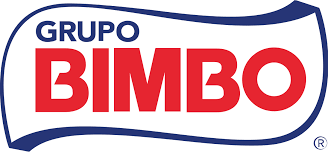

[Grupo Bimbo, S.A.B. de C.V.](http://grupobimbo.com/es) is a Mexican multinational company with a presence in over 33 countries located in the Americas, Europe, Asia, and Africa. It has an annual sales volume of 15 billion dollars and is currently listed on the Mexican stock exchange with the ticker BIMBO.

## Introduction

Planning a celebration is a balancing act of preparing just enough food to go around without being stuck eating the same leftovers for the next week. The key is anticipating how many guests will come. Grupo Bimbo must weigh similar considerations as it strives to meet daily consumer demand for fresh bakery products on the shelves of over 1 million stores along its 45,000 routes across Mexico.

![](https://grupobimbo-com-custom01-assets.s3.amazonaws.com/s3fs-public/grupo-bimbo-nuestras-marcas-productos_0_0.jpg) 

Currently, daily inventory calculations are performed by direct delivery sales employees who must single-handedly predict the forces of supply, demand, and hunger based on their personal experiences with each store. With some breads carrying a one week shelf life, the acceptable margin for error is small.



The following topics are covered in this notebook:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Train & evaluating different machine learning models
- Tuning hyperparameters to reduce overfitting to improve the model
- Making predictions on sample inputs

Let's install and import some required libraries before we begin.

In [ ]:
!pip install numpy pandas matplotlib seaborn --quiet

In [ ]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

     |████████████████████████████████| 173.5 MB 13 kB/s 
     |████████████████████████████████| 2.0 MB 52.1 MB/s 


Set the path for graphviz

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/HP/anaconda3/Library/bin/graphviz'

## Problem Statement

 
In this notebook, we will forecast the demand of a product for a given week, at a particular store based on historical sales data. Doing so will make sure consumers of Grupo Bimbo's over 100 bakery products aren’t staring at empty shelves, while also reducing the amount spent on refunds to store owners with surplus product unfit for sale.

The dataset we are given; [Grupo Bimbo Inventory Demand](https://www.kaggle.com/c/grupo-bimbo-inventory-demand/data) consists of 9 weeks of sales transactions in Mexico. Every week, there are delivery trucks that deliver products to the vendors. Each transaction consists of sales and returns. Returns are the products that are unsold and expired. The demand for a product in a certain week is defined as the sales this week subtracted by the return next week.

View and download the dataset here: https://www.kaggle.com/c/grupo-bimbo-inventory-demand/data

## Downloading the Data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library. Make sure to [accept the competition rules](https://www.kaggle.com/c/grupo-bimbo-inventory-demand/rules) before executing the following cell.

In [ ]:
import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
od.download('https://www.kaggle.com/c/grupo-bimbo-inventory-demand/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mitchellodili
Your Kaggle Key: ··········


100%|██████████| 465M/465M [00:01<00:00, 252MB/s]



Extracting archive ./grupo-bimbo-inventory-demand/grupo-bimbo-inventory-demand.zip to ./grupo-bimbo-inventory-demand


You'll be asked to provide your Kaggle credentials to download the data. Follow these instructions: http://bit.ly/kaggle-creds

In [ ]:
os.listdir('grupo-bimbo-inventory-demand')

['train.csv.zip',
 'sample_submission.csv.zip',
 'cliente_tabla.csv.zip',
 'producto_tabla.csv.zip',
 'town_state.csv.zip',
 'test.csv.zip']

The files `client_tabla.csv.zip` , `producto_tabla.csv.zip`,`sample_submission.csv.zip`, `test.csv.zip`, `town_state.csv.zip` and `train.csv.zip` have been downloaded and are all in zip format. Let's unzip them using the [`zipfile`](https://docs.python.org/3/library/zipfile.html) module.

In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile('grupo-bimbo-inventory-demand/cliente_tabla.csv.zip') as f:
    f.extractall(path = 'client-table')

In [ ]:
with ZipFile('grupo-bimbo-inventory-demand/producto_tabla.csv.zip') as f:
    f.extractall(path = 'product-table')

In [ ]:
with ZipFile('grupo-bimbo-inventory-demand/sample_submission.csv.zip') as f:
    f.extractall(path = 'sample_submission')

In [ ]:
with ZipFile('grupo-bimbo-inventory-demand/test.csv.zip') as f:
    f.extractall(path = 'test')

In [ ]:
with ZipFile('grupo-bimbo-inventory-demand/town_state.csv.zip') as f:
    f.extractall(path = 'town_state')

In [ ]:
%%time
with ZipFile('grupo-bimbo-inventory-demand/train.csv.zip') as f:
    f.extractall(path = 'train')

CPU times: user 13.2 s, sys: 3.31 s, total: 16.5 s
Wall time: 46.8 s


The dataset is extracted to the folder `client-table`. Let's view the contents of the folder using the [`os`](https://docs.python.org/3/library/os.html) module.

In [ ]:
os.listdir('client-table'), os.listdir('product-table'), os.listdir('sample_submission'), os.listdir('test'), os.listdir('town_state'), os.listdir('train')

(['cliente_tabla.csv'],
 ['producto_tabla.csv'],
 ['sample_submission.csv'],
 ['test.csv'],
 ['town_state.csv'],
 ['train.csv'])

Let's load the data into Pandas dataframes.

In [ ]:
%%time
client_df = pd.read_csv('client-table/cliente_tabla.csv')
product_df = pd.read_csv('product-table/producto_tabla.csv')
sample_submission_df = pd.read_csv('sample_submission/sample_submission.csv')
test_df = pd.read_csv('test/test.csv')
town_state_df = pd.read_csv('town_state/town_state.csv')

CPU times: user 3.45 s, sys: 783 ms, total: 4.23 s
Wall time: 4.22 s


In [ ]:
client_df.shape, product_df.shape, sample_submission_df.shape, test_df.shape, town_state_df.shape

((935362, 2), (2592, 2), (6999251, 2), (6999251, 7), (790, 3))

In [ ]:
sample_submission_df

,id,Demanda_uni_equil
0,0,7
1,1,7
2,2,7
3,3,7
4,4,7
...,...,...
6999246,6999246,7
6999247,6999247,7
6999248,6999248,7
6999249,6999249,7


In [ ]:
%%time
train_df = pd.read_csv('train/train.csv', 
                    dtype  = {'Semana' : 'int32',
                              'Agencia_ID' :'int32',
                              'Canal_ID' : 'int32',
                              'Ruta_SAK' : 'int32',
                              'Cliente-ID' : 'int64',
                              'Producto_ID':'int32',
                              'Venta_hoy':'float32',
                              'Venta_uni_hoy': 'int32',
                              'Dev_uni_proxima':'int32',
                              'Dev_proxima':'float32',
                              'Demanda_uni_equil':'int32'})

CPU times: user 34.4 s, sys: 11 s, total: 45.4 s
Wall time: 52 s


In [ ]:
train_df

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.139999,0,0.000000,3
1,3,1110,7,3301,15766,1216,4,33.520000,0,0.000000,4
2,3,1110,7,3301,15766,1238,4,39.320000,0,0.000000,4
3,3,1110,7,3301,15766,1240,4,33.520000,0,0.000000,4
4,3,1110,7,3301,15766,1242,3,22.920000,0,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...
74180459,9,25759,1,5517,4528866,32873,4,27.760000,0,0.000000,4
74180460,9,25759,1,5517,4528866,34226,4,37.040001,0,0.000000,4
74180461,9,25759,1,5517,4528866,45112,4,51.000000,0,0.000000,4
74180462,9,25759,1,5517,4547943,40217,3,26.940001,3,26.940001,0


In [ ]:
train_df.shape

(74180464, 11)

In [ ]:
train_df.Semana.value_counts()

3    11165207
4    11009593
5    10615397
9    10408713
8    10406868
7    10382849
6    10191837
Name: Semana, dtype: int64

In [ ]:
train_df = train_df.sample(1000000)

In [ ]:
train_df

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
15748437,4,1461,1,2805,4336341,37058,7,52.500000,0,0.0,7
25162398,5,1335,1,1153,206504,1230,1,16.670000,0,0.0,1
43412423,7,1120,1,1467,4103871,48421,1,4.580000,0,0.0,1
62805673,8,3214,1,1630,4426715,40217,5,44.900002,0,0.0,5
29707827,5,2021,1,1206,3589666,2665,6,96.000000,0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...
27752670,5,1623,1,1032,4666686,1109,2,30.020000,0,0.0,2
20988498,4,3211,1,1415,2295035,1242,5,38.200001,0,0.0,5
11217733,4,1111,1,1627,22250,44859,3,13.890000,0,0.0,3
18760031,4,2016,1,1065,176106,3631,3,49.049999,0,0.0,3


Let's save our work before continuing.

In [ ]:
jovian.commit(project = 'grupo-bimbo-inventory-demand')

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 

## Rename Columns into English

To ease understanding, extract column names and convert them to English as per the [Data description](https://www.kaggle.com/c/grupo-bimbo-inventory-demand/data)

In [ ]:
train_df.columns

In [ ]:
train_df = train_df.rename(columns = {'Semana': 'Week_Number', 'Agencia_ID': 'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID',
                                      'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID', 'Producto_ID':'Product_ID', 
                                      'Venta_uni_hoy':'Sales_Units_this_week', 'Venta_hoy':'Sales_this_week_pesos', 
                                      'Dev_uni_proxima':'Returns_units_next_week','Dev_proxima': 'Returns_next_week_pesos', 
                                      'Demanda_uni_equil':'Adjusted_Demand'})

In [ ]:
train_df.head()

In [ ]:
client_df.columns

In [ ]:
client_df = client_df.rename(columns = {'Cliente_ID':'Client_ID', 'NombreCliente':'Client_Name'})

In [ ]:
client_df.head()

In [ ]:
product_df.columns

In [ ]:
product_df = product_df.rename(columns = {'Producto_ID':'Product_ID', 'NombreProducto':'Product_Name'})

In [ ]:
product_df.head()

In [ ]:
test_df.columns

In [ ]:
test_df = test_df.rename(columns = {'id':'ID', 'Semana': 'Week_Number', 'Agencia_ID': 'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID',
                                    'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID','Producto_ID':'Product_ID'})

In [ ]:
test_df.head()

In [ ]:
town_state_df.columns

In [ ]:
town_state_df = town_state_df.rename(columns = {'Agencia_ID': 'Sales_Depot_ID', 'Town':'Town', 'State':'State'})

In [ ]:
town_state_df.head()

## Client Data Frame

There are duplicate Cliente_ID's (Client_IDs) in cliente_tabla (Client_Table), which means one Client(e)_ID may have multiple NombreCliente(Client_Names) that are very similar. This is due to the NombreCliente (CLient_Names) being noisy and not standardized in the raw data

Let's clean up and use this information. 

### Load in the Client Name data

Make sure all names uppercase (there are some mixed instances)

In [ ]:
client_df['Client_Name'] = client_df.Client_Name.str.upper()

In [ ]:
client_df.Client_Name.value_counts()

The methods used to generate the filter terms involved looking at the most frequent words/client names for clues about what types of establishments were mentioned in this data set.

Developing the filters took a fair amount of "human" sleuthing while looking at TF-IDF scores, frequency counts of Client names, as well as just general knowledge of common Spanish words used to refer to certain establishment types. Especially with all the noise provided by the Clients referred to only by a proper name, the filtered data is a proportionally small figure- but, significant.

Reference: [Classifying Client Type using Client Names](https://www.kaggle.com/abbysobh/classifying-client-type-using-client-names) by  Abderrahman Sobh 

Let's also generate a list of individual word frequency across all names

In [ ]:
# Let's also generate a list of individual word frequency across all names
def tfidf_score_list(data, list_len):
    from sklearn.feature_extraction.text import TfidfVectorizer
    v = TfidfVectorizer()

    data['New'] = 'na'
    a = " ".join(data['Client_Name'])
    data['New'][0] = a

    tfidf = v.fit_transform(data['New'])

    feature_names = v.get_feature_names()

    freq = []
    doc = 0
    feature_index = tfidf[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf[doc, x] for x in feature_index])
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
            freq.append((w.encode('utf-8'),s))
    
    del data['New']
    
    import numpy as np
    names = ['word','score']
    formats = ['S50','f8']
    dtype = dict(names = names, formats=formats)
    
    array = np.array(freq, dtype=dtype)

    b = np.sort(array, order='score')
    
    if list_len > len(b)+1:
        list_len = len(b)+1
    for i in range(1,list_len):
        print(b[-i])

In [ ]:
%%time
tfidf_score_list(client_df, 200)

Again, notice the prevalence of personal names. By looking at a long enough list, however, we can start to see some other useful terms appear such as particles of speech (i.e. 'ag', 'los', 'san') or more useful words like "super", "oxxo", "mini", "comodin". If I found a word that I thought represent a type of establishment, I'd double check it by doing a single search. If that search was fruitful and had a good amount of relevant results, I'd add it to my filter. An example of a single term search is below:


In [ ]:
client_df[client_df['Client_Name'].str.contains('.*CAFE.*')]

The result is a filter derived from hand-picking the best, most common, most interesting terms I could determine.

In [ ]:
# --- Begin Filtering for specific terms

# Note that the order of filtering is significant.
# For example: 
# The regex of .*ERIA.* will assign "FRUITERIA" to 'Eatery' rather than 'Fresh Market'.
# In other words, the first filters to occur have a bigger priority.

def filter_specific(data):
    
    # Known Large Company / Special Group Types
    data['Client_Name'] = data['Client_Name'].str.replace('.*REMISION.*','Consignment')
    data['Client_Name'] = data['Client_Name'].replace(['.*WAL MART.*','.*SAMS CLUB.*'],'Walmart', regex=True)
    data['Client_Name'] = data['Client_Name'].str.replace('.*OXXO.*','Oxxo Store')
    data['Client_Name'] = data['Client_Name'].str.replace('.*CONASUPO.*','Govt Store')
    data['Client_Name'] = data['Client_Name'].str.replace('.*BIMBO.*','Bimbo Store')
    
    # General term search for a random assortment of words I picked from looking at
    # their frequency of appearance in the data and common spanish words for these categories
    data['Client_Name'] = data['Client_Name'].replace(['.*COLEG.*','.*UNIV.*','.*ESCU.*','.*INSTI.*',\
                                                        '.*PREPAR.*'],'School', regex=True)
    data['Client_Name'] = data['Client_Name'].str.replace('.*PUESTO.*','Post')
    data['Client_Name'] = data['Client_Name'].replace(['.*FARMA.*','.*HOSPITAL.*','.*CLINI.*'],'Hospital/Pharmacy', regex=True)
    data['Client_Name'] = data['Client_Name'].replace(['.*CAFE.*','.*CREMERIA.*','.*DULCERIA.*',\
                                                        '.*REST.*','.*BURGER.*','.*TACO.*', '.*TORTA.*',\
                                                        '.*TAQUER.*','.*HOT DOG.*',\
                                                        '.*COMEDOR.*', '.*ERIA.*','.*BURGU.*'],'Eatery', regex=True)
    data['Client_Name'] = data['Client_Name'].str.replace('.*SUPER.*','Supermarket')
    data['Client_Name'] = data['Client_Name'].replace(['.*COMERCIAL.*','.*BODEGA.*','.*DEPOSITO.*',\
                                                            '.*ABARROTES.*','.*MERCADO.*','.*CAMBIO.*',\
                                                        '.*MARKET.*','.*MART .*','.*MINI .*',\
                                                        '.*PLAZA.*','.*MISC.*','.*ELEVEN.*','.*EXP.*',\
                                                         '.*SNACK.*', '.*PAPELERIA.*', '.*CARNICERIA.*',\
                                                         '.*LOCAL.*','.*COMODIN.*','.*PROVIDENCIA.*'
                                                        ],'General Market/Mart'\
                                                       , regex=True)

    data['Client_Name'] = data['Client_Name'].replace(['.*VERDU.*','.*FRUT.*'],'Fresh Market', regex=True)
    data['Client_Name'] = data['Client_Name'].replace(['.*HOTEL.*','.*MOTEL.*'],'Hotel', regex=True)


In [ ]:
%%time
filter_specific(client_df)

In [ ]:
# --- Begin filtering for more general terms
# The idea here is to look for names with particles of speech that would not appear in a person's name.
# i.e. "Individuals" should not contain any participles or numbers in their names.
def filter_participle(data):
    data['Client_Name'] = data['Client_Name'].replace([
            '.*LA .*','.*EL .*','.*DE .*','.*LOS .*','.*DEL .*','.*Y .*', '.*SAN .*', '.*SANTA .*',\
            '.*AG .*','.*LAS .*','.*MI .*','.*MA .*', '.*II.*', '.*[0-9]+.*'\
    ],'Small Franchise', regex=True)

In [ ]:
filter_participle(client_df)

In [ ]:
# Any remaining entries should be "Individual" Named Clients, there are some outliers.
# More specific filters could be used in order to reduce the percentage of outliers in this final set.
def filter_remaining(data_df):
    def function_word(data):
        # Avoid the single-words created so far by checking for upper-case
        if (data.isupper()) and (data != "NO IDENTIFICADO"): 
            return 'Individual'
        else:
            return data
    data_df['Client_Name'] = data_df['Client_Name'].map(function_word)

In [ ]:
filter_remaining(client_df)

With the filtering complete, let's look at the breakdown of how the data is classified now:

In [ ]:
client_df['Client_Name'].value_counts()

Finally, we can apply these new tags on the actual Training and Test data sets that have been provided!

In [ ]:
client_df

In [ ]:
'''%%time
train_df_Clients = train_df.merge(client_df.drop_duplicates(subset = 'Client_ID'), how = 'left')
test_df_Clients = test_df.merge(client_df.drop_duplicates(subset = 'Client_ID'), how = 'left')'''

In [ ]:
'''%%time
train_df_Clients'''

In [ ]:
'''%%time
test_df_Clients'''

## Exploring Products

Let's explore the product set metadata. 

Lessons adopted from Andrey Vykhodtsev's [Exploring Products](https://www.kaggle.com/vykhand/exploring-products) and Metabaron's [Basic Preprocessing for Products](https://www.kaggle.com/lyytinen/basic-preprocessing-for-products)

In [ ]:
product_df

In [ ]:
def get_product_agg(cols):
    df_train = pd.read_csv('train/train.csv', usecols = ['Semana', 'Producto_ID'] + cols,
                           dtype  = {'Semana': 'int32',
                                     'Producto_ID':'int32',
                                     'Venta_hoy':'float32',
                                     'Venta_uni_hoy': 'int32',
                                     'Dev_uni_proxima':'int32',
                                     'Dev_proxima':'float32',
                                     'Demanda_uni_equil':'int32'},nrows = 4000000)
    df_train = df_train.rename(columns = {'Semana': 'Week_Number', 'Agencia_ID': 'Sales_Depot_ID', 'Canal_ID':'Sales_Channel_ID',
                                      'Ruta_SAK':'Route_ID', 'Cliente_ID':'Client_ID', 'Producto_ID':'Product_ID', 
                                      'Venta_uni_hoy':'Sales_Units_this_week', 'Venta_hoy':'Sales_this_week_pesos', 
                                      'Dev_uni_proxima':'Returns_units_next_week','Dev_proxima': 'Returns_next_week_pesos', 
                                      'Demanda_uni_equil':'Adjusted_Demand'})
    
    agg  = df_train.groupby(['Week_Number', 'Product_ID'], as_index=False).agg(['count','sum', 'min', 'max','median','mean'])
    agg.columns  =  ['_'.join(col).strip() for col in agg.columns.values]
    del(df_train)
    return agg

In [ ]:
agg1 = get_product_agg(['Demanda_uni_equil','Dev_uni_proxima'])

In [ ]:
agg1

In [ ]:
agg1.shape

In [ ]:
agg2 = get_product_agg(['Venta_uni_hoy'])
agg = agg1.join(agg2)

In [ ]:
agg2

In [ ]:
agg

Let's preprocess products a little bit. I borrowed some of the preprocessing from [here](https://www.kaggle.com/lyytinen/basic-preprocessing-for-products)

Let's look at the product set

In [ ]:
product_df

In [ ]:
product_df['Short_Name'] = product_df.Product_Name.str.extract('^(\D*)', expand=False)
product_df['Brand'] = product_df.Product_Name.str.extract('^.+\s(\D+) \d+$', expand=False)
w = product_df.Product_Name.str.extract('(\d+)(Kg|g)', expand=True)
product_df['weight'] = w[0].astype('float')*w[1].map({'Kg':1000, 'g':1})
product_df['pieces'] =  product_df.Product_Name.str.extract('(\d+)p ', expand=False).astype('float')
product_df

In [ ]:
product_df.Short_Name.value_counts(dropna = False).to_frame().reset_index().rename(columns={'index':'Short_Name','Short_Name':'count'})

There are some weird products that weight 42 Kilos. In my truncated dataset, there are products that weigh as much as 25 Kgs. Check out this Exhibitor :

![Exhibidor bimbo](https://mir-s3-cdn-cf.behance.net/project_modules/disp/55c94f24003843.5632c737c062c.jpeg)

In [ ]:
sns.displot(product_df.weight.dropna());

Let's examine the distribution of pieces

In [ ]:
sns.displot(product_df.pieces.dropna());

Most of the purchases are 50 products or less, however there are players who order up to 200 pieces. I presume these are the big players

Lets clean up product names a bit, we have ~1000 unique names once we cleaned the weights, but there is much more work to be done

Products have some abbreviation leftovers that I did not clean, products have similar names but different word forms, etc.

In [ ]:
product_df.Short_Name.nunique()

Let's process the product dataset.

The process of converting data to something a computer can understand is referred to as pre-processing. One of the major forms of pre-processing is to filter out useless data. In natural language processing, useless words (data), are referred to as `stop words`. 

**Stop Words**: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. 
We would not want these words to take up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to stop words. NLTK(Natural Language Toolkit) in python has a list of stopwords stored in 16 different languages. You can find them in the nltk_data directory. home/pratima/nltk_data/corpora/stopwords is the directory address.(Do not forget to change your home directory name)

Let's clean stop words and leave only the word stems (I did not clean abbreviations, sorry)

In [ ]:
%%time
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('spanish'))

In [ ]:
product_df['Short_Name_Processed'] = (product_df['Short_Name']
                                        .map(lambda x: " ".join([i for i in x.lower()
                                                                 .split() if i not in stopwords.words("spanish")])))

In [ ]:
product_df['Short_Name_Processed'].nunique()

In [ ]:
product_df['Short_Name_Processed'].nunique() - product_df.Short_Name.nunique()

Let's reduce words further by `stemming`

**Stemming**: It is the process of reducing the word to its word stem that affixes to suffixes and prefixes or to roots of words known as a lemma. In simple words stemming is reducing a word to its base word or stem in such a way that the words of similar kind lie under a common stem. For example – The words care, cared and caring lie under the same stem ‘care’. Stemming is important in natural language processing(NLP).

In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("spanish")

In [ ]:
print(stemmer.stem("Tortillas"))

In [ ]:
product_df['Short_Name_Processed'] = (product_df['Short_Name_Processed']
                                        .map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))

In [ ]:
product_df.Short_Name_Processed.nunique()

A further 29

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1000) 

product_bag_words = vectorizer.fit_transform(product_df.Short_Name_Processed).toarray()
product_bag_words.shape

In [ ]:
vectorizer.get_feature_names_out()

In [ ]:
product_bag_words = pd.concat([product_df.Product_ID, 
                               pd.DataFrame(product_bag_words, 
                                            columns= vectorizer.get_feature_names(), index = product_df.index)], axis=1)
product_bag_words.head()

In [ ]:
product_bag_words.drop('Product_ID', axis=1).sum().sort_values(ascending=False).head(100).to_frame().rename(columns={0:'count'})

Let's have a look, what is the product with the biggest demand of all times

In [ ]:
df = pd.merge(agg1.reset_index(), product_df, on = 'Product_ID', how = 'left').groupby('Short_Name')['Adjusted_Demand_sum'].sum().sort_values(ascending=False)
df

In [ ]:
plt.figure(figsize= (12,15))
df.head(50).sort_values().plot(kind = 'barh')
plt.title('Adjusted Product Demand');

The best seller is by far Nito. A quick look at the distributions

In [ ]:
sns.displot(df);

In [ ]:
sns.displot(np.log1p(df));

Expanding the aggregate

In [ ]:
df = (pd.merge(agg.reset_index(), product_df, on='Product_ID', how='left').
      groupby('Short_Name')[['Adjusted_Demand_sum', 'Sales_Units_this_week_sum', 'Returns_units_next_week_sum', 
                            'Returns_units_next_week_count']]
      .sum().sort_values(by = 'Adjusted_Demand_sum', ascending=False))

In [ ]:
df.describe().T

There are interesting things. There are products for which `Adjusted_Demand_sum` = 0 and other fields are not equal to 0

In [ ]:
df[df.Adjusted_Demand_sum == 0].count()

In [ ]:
df[df.Adjusted_Demand_sum == 0]

Similarly there are products with 0 sales and only returns

In [ ]:
df[df.Sales_Units_this_week_sum == 0]

There are products that were never returned

In [ ]:
df[df.Returns_units_next_week_sum == 0].count()

In [ ]:
df[df.Returns_units_next_week_sum == 0].head(20)

Let's cut products into 10 quantiles by summary adjusted demand.

In [ ]:
df['Q'] = pd.qcut(df.Adjusted_Demand_sum, 10)
df.Q.value_counts()

In [ ]:
df[df.Q == '[0, 49]'].index.values

Distribution of returns by product

In [ ]:
sns.distplot(df.Adjusted_Demand_sum);

In [ ]:
sns.distplot(np.log1p(df.Adjusted_Demand_sum))

Distribution of counts by product

In [ ]:
sns.distplot(df.Returns_units_next_week_count);

In [ ]:
sns.distplot(np.log1p(df.Returns_units_next_week_count))

Lets aggregate by week and `Short_Name` now

In [ ]:
df_hmp = (pd.merge(agg.reset_index(), product_df, on='Product_ID', how='left').
      groupby(['Week_Number','Short_Name'])[['Adjusted_Demand_sum', 'Sales_Units_this_week_sum', 'Returns_units_next_week_sum', 
                            'Returns_units_next_week_count']].sum().reset_index())

In [ ]:
df_hmp

A quick check if demand distribution changes week to week

In [ ]:
df_hmp['log1p_Adjusted_Demand_sum'] = np.log1p(df_hmp.Adjusted_Demand_sum)
g = sns.FacetGrid(df_hmp, row = 'Week_Number')
g = g.map(sns.distplot, 'log1p_Adjusted_Demand_sum')


Let's save our work before continuing

Let's merge `product_df` onto `train_df_Clients` and `test_df_Clients`

In [ ]:
product_df

In [ ]:
train_df_Clients

In [ ]:
test_df_Clients

In [ ]:
%%time
train_merged_df = train_df_Clients.merge(product_df, on = 'Product_ID', how = 'left')

In [ ]:
train_merged_df

In [ ]:
%%time
test_merged_df = test_df_Clients.merge(product_df, on = 'Product_ID', how = 'left')

In [ ]:
test_merged_df

In [ ]:
jovian.commit()

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [ ]:
train_merged_df.info()

In [ ]:
test_merged_df.info()

### Deal with NA Values

Our objective is to predict adjusted demand. Let's look at the missing values to determine what approach to use 

In [ ]:
train_merged_df.isna().sum()

In [ ]:
test_merged_df.isna().sum()

The missing values are in an extract of products we got from feature engineering i.e. Weight and pieces. We will leave that out in choosing our input and target variables


### Input and Target Columns

Let's select the columns that we'll use for training.

In [ ]:
train_merged_df.columns

In [ ]:
test_merged_df.columns

In [ ]:
input_cols = ['Week_Number', 'Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID',
       'Client_ID', 'Product_ID', 'Client_Name']
target_col = ['Adjusted_Demand']

In [ ]:
%%time
inputs = train_merged_df[input_cols].copy()
targets = train_merged_df[target_col].copy()

In [ ]:
%%time
test_inputs = test_merged_df[input_cols].copy()

Let's also identify numeric and categorical columns. Note there are categorical columns that look numeric. We will however treat numeric columns as numeric and scale thereafter

In [ ]:
inputs

In [ ]:
%%time
inputs.info()

In [ ]:
numeric_cols = ['Week_Number', 'Sales_Depot_ID', 'Sales_Channel_ID', 'Route_ID','Client_ID']
categorical_cols = ['Client_Name']

### Scale Numeric Values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [ ]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [ ]:
inputs

### Encode Categorical Columns

Let's one-hot encode categorical columns.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
%%time
encoder = OneHotEncoder(sparse = 'False', handle_unknown = 'ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [ ]:
encoded_cols

In [ ]:
inputs[categorical_cols]

In [ ]:
encoder.transform(inputs[categorical_cols])

In [ ]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [ ]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Create the model
rf = RandomForestRegressor(n_jobs = -1, random_state = 42)

In [ ]:
#Fit the model
rf.fit(X, targets)

In [ ]:
targets.shape

In [ ]:
targets

Make predictions using the random forest regressor.

In [ ]:
rf_train_preds = rf.predict(X)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
rf_train_rmse = mean_squared_error(rf_train_preds, targets, squared = False)

In [ ]:
rf_train_rmse

In [ ]:
rf_test_preds = rf.predict(X_test)

In [ ]:
rf_test_preds.shape

## Hyperparameter Tuning

Let us now tune the hyperparameters of our model. You can find the hyperparameters for `RandomForestRegressor` here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Let's define a helper function `test_params` which can test the given value of one or more hyperparameters.

In [ ]:
def test_params(**params):
    model = RandomForestRegressor(n_jobs = -1, random_state = 42).fit(X, targets)
    train_rmse = mean_squared_error(model.predict(X), targets, squared = False)
    return train_rmse

It can be used as follows:

In [ ]:
test_params(n_estimators=20, max_depth=20)

test_params(n_estimators=50, max_depth=10, min_samples_leaf=4, max_features=0.4)